In [54]:
import pandas as pd
from tqdm import tqdm
import re
import sentencepiece as spm
import matplotlib.pyplot as plt
import numpy as np
from sklearn import preprocessing
import pickle
from collections import Counter
# function for removing emojis in texts
import emoji

In [28]:
# remove emojis, line carriage, @, and links from text
def dirtyRemoval(text):
    # remove emojis in texts
    temp = emoji.get_emoji_regexp().sub(u'', text)
    # merge multiple lines
    temp = temp.replace("\n", "")
    # remove '@'
    temp = re.sub(r'\@\w+\s', '', temp)
    # remove links
    temp = re.sub(r"http\S+", "", temp)
    return temp

In [42]:
temp1 = """RT @Hitz1039Fm: #MusikBox  🔥 w/ @andydosty #DostyMan 🇬🇭

▶️  I BELIEVE – @ANDYDOSTY  🎧

cc: @MrHaglah @MawuWan @FlyNimaBoy 💯 #Hitz1039FM 📢"""

print(dirtyRemoval(temp1))

RT @Hitz1039Fm: #MusikBox   w/ #DostyMan ️  I BELIEVE –  cc:  #Hitz1039FM 


In [1]:
# import sentencepiece tokenizer
import sys
!{sys.executable} -m pip install sentencepiece

    100% |████████████████████████████████| 1.1MB 9.4MB/s eta 0:00:01
You are using pip version 19.1.1, however version 19.3.1 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.


In [40]:
# test set
id_text = pd.read_csv('../data/full_test_id_text.csv', sep='\t', header=[0], lineterminator='\n')
id_text.columns = ['ID', 'TEXT']

id_emoji = pd.read_csv('../data/full_test_plaintext.txt', sep='\t', header=[0], lineterminator='\n')
id_emoji.columns = ['ID','EMOJI']

print(len(id_text))
print(len(id_emoji))

572095
1000000


In [41]:
print(type(id_emoji.ID.iloc[10]))
print(type(id_text.ID.iloc[10]))
id_text['ID'] = id_text['ID'].apply(str)

<class 'str'>
<class 'numpy.int64'>


In [42]:
# inner join the two dataframes
text_emoji = pd.merge(id_text, id_emoji, on="ID", how="inner")

print(len(text_emoji))

572095


In [43]:
text_emoji['TEXT'] = text_emoji.TEXT.apply(dirtyRemoval)

In [44]:
text_emoji.to_csv('../data/text_emoji_test.txt', index=False)

In [45]:
# validation set
id_text = pd.read_csv('../data/full_valid_id_text.csv', sep='\t', header=[0], lineterminator='\n')
id_text.columns = ['ID', 'TEXT']
id_text['ID'] = id_text['ID'].apply(str)

id_emoji = pd.read_csv('../data/full_valid_plaintext.txt', sep='\t', header=[0], lineterminator='\n')
id_emoji.columns = ['ID','EMOJI']

print(len(id_text))
print(len(id_emoji))

571932
1000000


In [46]:
text_emoji = pd.merge(id_text, id_emoji, on="ID", how="inner")
print(len(text_emoji))
text_emoji['TEXT'] = text_emoji.TEXT.apply(dirtyRemoval)
text_emoji.to_csv('../data/text_emoji_valid.txt', index=False)

571932


In [47]:
# training set
id_text = pd.read_csv('../data/full_train_id_text.csv', sep='\t', header=[0], lineterminator='\n')
id_text.columns = ['ID', 'TEXT']
id_text['ID'] = id_text['ID'].apply(str)

id_emoji = pd.read_csv('../data/full_train_plaintext.txt', sep='\t', header=[0], lineterminator='\n')
id_emoji.columns = ['ID','EMOJI']


print(len(id_text))
print(len(id_emoji))

7443390
12997219


In [49]:
text_emoji = pd.merge(id_text, id_emoji, on="ID", how="inner")
print(len(text_emoji))
text_emoji['TEXT'] = text_emoji.TEXT.apply(dirtyRemoval)
text_emoji.to_csv('../data/text_emoji_train.txt', index=False)

7443390


In [50]:
# text for training tokenizer
with open('../data/text_train.txt', 'w') as f:
    for item in text_emoji['TEXT'].tolist():
        f.write("%s\n" % item)


In [51]:
# train the SentencePiece tokenizer

spm.SentencePieceTrainer.Train('--input=../data/text_train.txt --model_prefix=tokenizer --vocab_size=32000')


True

In [5]:
# load tokenizer
tokenizer = spm.SentencePieceProcessor()
tokenizer.Load('./tokenizer.model')

True

In [7]:
# tokenize test set texts
# for i in ['test', 'valid', 'train']:
for i in ['train']:
    temp = pd.read_csv('../data/text_emoji_%s.txt' % i, sep=',', header=[0], lineterminator='\n')
    temp.columns = ['ID', 'TEXT', 'EMOJI']
    temp['TEXT'] = temp.TEXT.apply(str)
    temp['TEXT_ID'] = temp.TEXT.apply(tokenizer.EncodeAsIds)
    temp.to_csv('../data/%s.txt' % i, index=False)

In [61]:
print(test['TEXT_ID'])
# check sentence length statistics
tempList = test.TEXT_ID.tolist()
lengthList = [len(i) for i in tempList]
maxLength = max(lengthList)
minLength = min(lengthList)
avgLength = sum(lengthList)/len(lengthList)
print(maxLength, minLength, avgLength)



0                                               [1182, 654]
1         [12, 9, 2554, 13706, 13, 981, 2199, 230, 1713,...
2         [3962, 169, 425, 4, 159, 1576, 1004, 1407, 124...
3         [12, 9, 341, 527, 982, 2632, 7175, 117, 1152, ...
4              [78, 709, 853, 3, 4, 23, 30, 275, 23234, 28]
5         [5647, 4055, 16, 1645, 4055, 36, 6, 18630, 477...
6                           [32, 95, 33, 25, 18, 9224, 711]
7           [3, 1499, 8, 292, 21, 8, 7, 42, 11, 178, 7, 40]
8                          [259, 46, 44, 39, 56, 197, 1011]
9                         [69, 4353, 175, 104, 11, 154, 92]
10                             [3, 8976, 34, 29, 1309, 296]
11        [210, 249, 8, 52, 5679, 20, 2433, 24, 276, 321...
12        [155, 19927, 5, 25, 14, 28796, 26, 2583, 1488,...
13                          [191, 1109, 809, 22, 6939, 114]
14                                [121, 4, 5, 708, 570, 36]
15                                         [22181, 91, 130]
16                          [1055, 30, 3

(array([1.0000e+00, 1.0208e+04, 2.5204e+04, 2.9432e+04, 3.2281e+04,
        3.2141e+04, 3.0373e+04, 2.8935e+04, 2.8581e+04, 2.7466e+04,
        2.6347e+04, 2.4616e+04, 2.3490e+04, 2.1731e+04, 1.9771e+04,
        1.8596e+04, 1.7322e+04, 1.6170e+04, 1.5012e+04, 1.3926e+04,
        1.3053e+04, 1.2271e+04, 1.1247e+04, 1.0710e+04, 9.8980e+03,
        9.1470e+03, 8.5290e+03, 7.9160e+03, 6.9940e+03, 6.3800e+03,
        5.9660e+03, 5.4500e+03, 4.6540e+03, 3.7850e+03, 3.2740e+03,
        2.5850e+03, 2.0490e+03, 1.6750e+03, 1.3400e+03, 9.8100e+02,
        6.4700e+02, 5.1100e+02, 3.8300e+02, 2.9200e+02, 1.7700e+02,
        1.3900e+02, 9.9000e+01, 8.2000e+01, 6.5000e+01, 5.1000e+01,
        2.9000e+01, 3.4000e+01, 1.9000e+01, 1.3000e+01, 1.0000e+01,
        7.0000e+00, 1.1000e+01, 3.0000e+00, 7.0000e+00, 2.0000e+00,
        0.0000e+00, 3.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        1.0000e+00, 0.0000e+00, 0.0000e+00, 1.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 1.0000e+00, 0.00

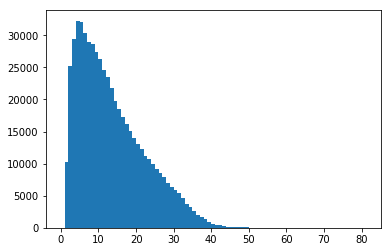

In [63]:

plt.hist(lengthList, bins=np.arange(minLength, maxLength+1))

In [60]:
sum([1,2,3])/len([1,2,3])

2.0

In [64]:
test.to_csv('../data/test.txt', index=False)

In [9]:
# get all classes from training set
train = pd.read_csv('../data/train.txt', sep=',', header=[0], lineterminator='\n')
train.columns = ['ID', 'TEXT', 'EMOJI', 'TEXT_ID']
emoji_set = set()
for i in train['EMOJI'].tolist():
    emoji_set = emoji_set.union(set(i.split(',')))
    
print(len(emoji_set))

1300


In [28]:
# encode multi-class labels

le = preprocessing.LabelEncoder()

emoji_list = list(emoji_set)
le.fit(emoji_list)

len(le.classes_)


1300

In [29]:
# save the label encoder using pickle

with open('labelEncoder.pickle', 'wb') as handle:
    pickle.dump(le, handle, protocol=pickle.HIGHEST_PROTOCOL)

    
    
# use scripts below to load model
# with open('labelEncoder.pickle', 'rb') as handle:
#     le = pickle.load(handle)

In [33]:
# split the string in "EMOJI" into multiple emoji IDs
def listEmoji(string):
    return string.split(',')


In [34]:
train['EMOJI'] = train.EMOJI.apply(listEmoji)
print(train.EMOJI)



0                [762, 859, 865]
1                     [77, 1381]
2                         [1420]
3                         [1438]
4                         [1403]
5             [1107, 1424, 1466]
6                   [1056, 1381]
7                         [1447]
8               [550, 764, 1069]
9                   [1105, 1403]
10              [174, 550, 1097]
11                   [763, 1057]
12                        [1397]
13                        [1056]
14                   [761, 1475]
15                         [865]
16                        [1381]
17                     [47, 883]
18                        [1445]
19                        [1381]
20                        [1381]
21                        [1381]
22                        [1466]
23                        [1407]
24                        [1421]
25                        [1447]
26                        [1381]
27                        [1466]
28                    [763, 883]
29         [763, 764, 765, 1341]
          

In [35]:
train['EMOJI_ID'] = train.EMOJI.apply(le.transform)
print(train.EMOJI_ID)

0               [1157, 1243, 1245]
1                      [1165, 317]
2                            [361]
3                            [380]
4                            [342]
5                   [50, 365, 394]
6                        [23, 317]
7                            [390]
8                  [952, 1159, 27]
9                        [48, 342]
10                  [521, 952, 38]
11                      [1158, 24]
12                           [334]
13                            [23]
14                     [1156, 398]
15                          [1245]
16                           [317]
17                     [862, 1250]
18                           [388]
19                           [317]
20                           [317]
21                           [317]
22                           [394]
23                           [346]
24                           [362]
25                           [390]
26                           [317]
27                           [394]
28                  

In [48]:
train.to_csv('../data/train_final.txt', index=False)

(array([1.9700e+02, 8.0000e+00, 2.6700e+02, ..., 1.0753e+04, 1.2900e+03,
        2.2990e+03]),
 array([   0,    1,    2, ..., 1297, 1298, 1299]),
 <a list of 1299 Patch objects>)

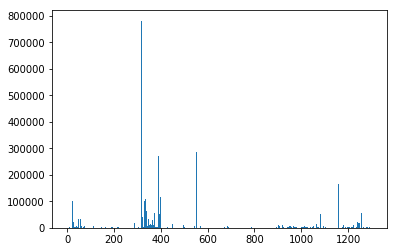

In [52]:
# Statistics for class labels:

allTrainEmoji = []
for i in train['EMOJI_ID'].tolist():
    allTrainEmoji += list(set(i.tolist()))

plt.hist(allTrainEmoji, bins=np.arange(0, len(le.classes_)))




In [56]:
# Counts for each label
counts = Counter(allTrainEmoji)

# 5 most common emojis
mostCommon5 = counts.most_common(5)
print(mostCommon5)

# Original IDs (+2 to refer to CSV mapping) of the most common 5 emojis
originalID = le.inverse_transform([i[0] for i in mostCommon5])
print("originalID: ", originalID)

# average counts
print(sum(counts.values())/len(counts.values()))


[(317, 782111), (329, 302374), (365, 287556), (552, 287442), (390, 269360)]
originalID:  ['1381' '1392' '1424' '186' '1447']
7735.71


In [47]:
# create CSR Matrix based on EMOJI_ID
shape_csr = (len(train), len(le.classes_))

row = []
col = []

row_idx = 0
for c, emoji_ids in enumerate(train.EMOJI_ID.tolist()):
    tempEmoji = set(emoji_ids)
    row += [row_idx] * len(tempEmoji)  
    col += emoji_ids.tolist()
    row_idx += 1
        


7443390

In [36]:
print(len(train))

7443390
